# import

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

import featuretools as ft

import gc
import os
os.listdir("./data/")

['all.zip',
 'Data_Dictionary.xlsx',
 'historical_transactions.csv',
 'merchants.csv',
 'new_merchant_transactions.csv',
 'sample_submission.csv',
 'test.csv',
 'train.csv']

# cards <- train & test

In [26]:
train = pd.read_csv("./data/train.csv", nrows=1000)
train["first_active_month"] = pd.to_datetime(train.first_active_month)

In [27]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


# transactions <- historical & new

In [3]:
history_transactions = pd.read_csv("./data/historical_transactions.csv", nrows=50000)
new_transactions = pd.read_csv("./data/new_merchant_transactions.csv", nrows=50000)

In [4]:
all_transactions = pd.concat([history_transactions, new_transactions])
print(all_transactions.shape)
all_transactions.head()

(100000, 14)


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [5]:
del history_transactions, new_transactions
gc.collect()

0

In [6]:
all_transactions["purchase_date"] = pd.to_datetime(all_transactions.purchase_date)

In [7]:
print("shape:", all_transactions.shape[0])
print("card_id.nunique:", all_transactions.card_id.nunique())
print("merchant_id.nunique:", all_transactions.merchant_id.nunique())
print("city_id.nunique:", all_transactions.city_id.nunique())
print("state_id.nunique:", all_transactions.state_id.nunique())

shape: 100000
card_id.nunique: 3958
merchant_id.nunique: 36482
city_id.nunique: 301
state_id.nunique: 24


In [8]:
def get_yearmonth(series):
    return series.dt.year * 100 + series.dt.month

all_transactions["purchase_month"] = get_yearmonth(all_transactions.purchase_date)
all_transactions["hour"] = all_transactions.purchase_date.dt.hour

In [10]:
all_transactions.dtypes

authorized_flag                 object
card_id                         object
city_id                          int64
category_1                      object
installments                     int64
category_3                      object
merchant_category_id             int64
merchant_id                     object
month_lag                        int64
purchase_amount                float64
purchase_date           datetime64[ns]
category_2                     float64
state_id                         int64
subsector_id                     int64
purchase_month                   int64
hour                             int64
dtype: object

## downcast

In [11]:
all_transactions.isnull().sum()

authorized_flag            0
card_id                    0
city_id                    0
category_1                 0
installments               0
category_3              1280
merchant_category_id       0
merchant_id              714
month_lag                  0
purchase_amount            0
purchase_date              0
category_2              6389
state_id                   0
subsector_id               0
purchase_month             0
hour                       0
dtype: int64

In [12]:
all_transactions.category_3.value_counts()

A    49730
B    43866
C     5124
Name: category_3, dtype: int64

In [13]:
all_transactions.category_3.isnull().sum()

1280

In [14]:
import imp
import my_preprocessing
imp.reload(my_preprocessing)
from my_preprocessing import MyLabelEncoder

In [15]:
encoder_set = {}

for col in ["authorized_flag", "city_id", "category_1", "category_3"]:
    encoder = MyLabelEncoder()
    all_transactions[col] = encoder.fit_transform(all_transactions[col].values)
    encoder_set[col] = encoder
    print("encode", col, encoder.value_map_)

transaction_col_int32 = [   
"authorized_flag",
"city_id",
"category_1",
"installments",
"category_3",
"merchant_category_id",
"month_lag",
"purchase_amount",
"category_2",
"state_id",
"subsector_id",
"purchase_month",
"hour"
]

for col in transaction_col_int32:
    all_transactions[col] = all_transactions[col].astype(np.float32)
    print("downcast", col)

encode authorized_flag {'Y': 0, 'N': 1, nan: -1, 'nan': -1, 'XNA': -1}
encode city_id {88: 0, 333: 1, 3: 2, -1: 3, 69: 4, 233: 5, 322: 6, 138: 7, 226: 8, 330: 9, 278: 10, 221: 11, 19: 12, 331: 13, 211: 14, 209: 15, 193: 16, 11: 17, 161: 18, 105: 19, 329: 20, 42: 21, 251: 22, 338: 23, 344: 24, 87: 25, 63: 26, 229: 27, 170: 28, 135: 29, 107: 30, 20: 31, 57: 32, 17: 33, 212: 34, 277: 35, 280: 36, 117: 37, 85: 38, 301: 39, 25: 40, 86: 41, 96: 42, 38: 43, 283: 44, 116: 45, 188: 46, 250: 47, 231: 48, 158: 49, 272: 50, 311: 51, 49: 52, 296: 53, 148: 54, 90: 55, 275: 56, 108: 57, 30: 58, 302: 59, 143: 60, 66: 61, 291: 62, 137: 63, 147: 64, 4: 65, 163: 66, 24: 67, 109: 68, 314: 69, 131: 70, 2: 71, 144: 72, 340: 73, 62: 74, 160: 75, 157: 76, 216: 77, 53: 78, 149: 79, 47: 80, 169: 81, 14: 82, 342: 83, 26: 84, 120: 85, 56: 86, 162: 87, 213: 88, 259: 89, 247: 90, 264: 91, 288: 92, 12: 93, 223: 94, 304: 95, 230: 96, 155: 97, 106: 98, 279: 99, 140: 100, 23: 101, 36: 102, 126: 103, 122: 104, 52: 105, 

In [23]:
all_transactions.dtypes

index                            int64
authorized_flag                float32
card_id                         object
city_id                        float32
category_1                     float32
installments                   float32
category_3                     float32
merchant_category_id           float32
merchant_id                     object
month_lag                      float32
purchase_amount                float32
purchase_date           datetime64[ns]
category_2                     float32
state_id                       float32
subsector_id                   float32
purchase_month                 float32
hour                           float32
dtype: object

In [17]:
import sys

In [18]:
sys.getsizeof(all_transactions) / 1024 / 1024

20.19068145751953

In [48]:
all_transactions["transaction_id"] = np.arange(all_transactions.shape[0])

In [49]:
all_transactions.head().T

,0,1,2,3,4
transaction_id,0,1,2,3,4
authorized_flag,0,0,0,0,0
card_id,C_ID_4e6213e9bc,C_ID_4e6213e9bc,C_ID_4e6213e9bc,C_ID_4e6213e9bc,C_ID_4e6213e9bc
city_id,0,0,0,0,0
category_1,0,0,0,0,0
installments,0,0,0,0,0
category_3,0,0,0,0,0
merchant_category_id,80,367,80,560,80
merchant_id,M_ID_e020e9b302,M_ID_86ec983688,M_ID_979ed661fc,M_ID_e6d5ae8ea6,M_ID_e020e9b302
month_lag,-8,-7,-6,-5,-11


# merchants

In [19]:
merchants = pd.read_csv("./data/merchants.csv", nrows=3000)

In [31]:
merchants.merchant_id.nunique()

2998

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


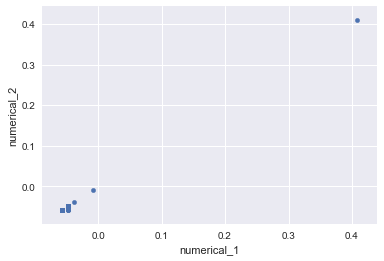

In [33]:
merchants[["numerical_1", 'numerical_2']].plot(kind="scatter", x="numerical_1", y="numerical_2")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


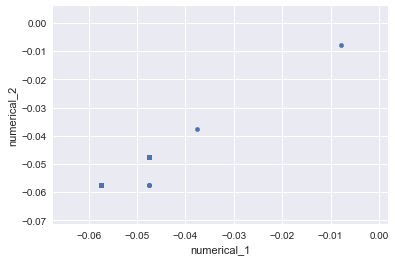

In [34]:
merchants[merchants.numerical_1 < 0.2][["numerical_1", 'numerical_2']].plot(kind="scatter", x="numerical_1", y="numerical_2")

In [35]:
merchants_vc = merchants.merchant_id.value_counts()

In [36]:
merchants_vc[merchants_vc > 1]

M_ID_0039220eb3    2
M_ID_c0b712e11a    2
Name: merchant_id, dtype: int64

In [37]:
merchants[merchants.merchant_id.isin({"M_ID_0039220eb3", "M_ID_c0b712e11a"})]

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
53,M_ID_c0b712e11a,35,823,25,-0.057471,-0.057471,N,E,E,1.00,...,1.00,1.000000,1,1.00,1.000000,1,N,231,9,1.0
54,M_ID_c0b712e11a,35,823,25,-0.007896,-0.007896,N,E,E,1.01,...,1.01,1.097119,6,1.20,1.190741,12,N,231,9,1.0
111,M_ID_0039220eb3,35,836,5,-0.057471,-0.057471,Y,E,E,0.66,...,0.66,0.666667,3,0.66,0.666667,3,Y,-1,-1,NaN
112,M_ID_0039220eb3,35,836,5,0.408530,0.408530,Y,C,D,1.17,...,1.17,1.087939,6,1.19,0.997021,12,Y,-1,-1,NaN


# entity set

In [23]:
help(ft.EntitySet)

Help on class EntitySet in module featuretools.entityset.entityset:

class EntitySet(builtins.object)
 |  Stores all actual data for a entityset
 |  
 |  Attributes:
 |      id
 |      entity_dict
 |      relationships
 |      time_type
 |  
 |  Properties:
 |      metadata
 |  
 |  Methods defined here:
 |  
 |  __dask_tokenize__(self)
 |  
 |  __eq__(self, other, deep=False)
 |      Return self==value.
 |  
 |  __getitem__(self, entity_id)
 |      Get entity instance from entityset
 |      
 |      Args:
 |          entity_id (str): Id of entity.
 |      
 |      Returns:
 |          :class:`.Entity` : Instance of entity. None if entity doesn't
 |              exist.
 |      
 |      Example:
 |          >>> my_entityset[entity_id]
 |          <Entity: id>
 |  
 |  __init__(self, id, entities=None, relationships=None)
 |      Creates EntitySet
 |      
 |      Args:
 |          id (str) : Unique identifier to associate with this instance
 |      
 |          entities (dict[str -> tup

In [24]:
es = ft.EntitySet("card-transaction-merchant")

In [28]:
es.entity_from_dataframe(entity_id="card",
                         dataframe=train,
                         index="card_id",
                         time_index="first_active_month")

Entityset: card-transaction-merchant
  Entities:
    card [Rows: 1000, Columns: 6]
  Relationships:
    No relationships

In [38]:
es.entity_from_dataframe(entity_id="merchant",
                         dataframe=merchants.drop_duplicates(subset=["merchant_id"]),
                         index="merchant_id")

Entityset: card-transaction-merchant
  Entities:
    card [Rows: 1000, Columns: 6]
    merchant [Rows: 2998, Columns: 22]
  Relationships:
    No relationships

In [50]:
es.entity_from_dataframe(entity_id="transaction",
                         dataframe=all_transactions,
                         index="transaction_id",
                         time_index="purchase_date")

Entityset: card-transaction-merchant
  Entities:
    card [Rows: 1000, Columns: 6]
    merchant [Rows: 2998, Columns: 22]
    transaction [Rows: 100000, Columns: 17]
  Relationships:
    No relationships

In [51]:
r_card_transaction = ft.Relationship(es["card"]["card_id"],
                                     es["transaction"]["card_id"])
es = es.add_relationship(r_card_transaction)

In [53]:
r_merchant_transaction = ft.Relationship(es["merchant"]["merchant_id"],
                                         es["transaction"]["merchant_id"])
es = es.add_relationship(r_merchant_transaction)

In [54]:
es

Entityset: card-transaction-merchant
  Entities:
    card [Rows: 1000, Columns: 6]
    merchant [Rows: 2998, Columns: 22]
    transaction [Rows: 100000, Columns: 17]
  Relationships:
    transaction.card_id -> card.card_id
    transaction.merchant_id -> merchant.merchant_id

# features

In [62]:
features, feature_names = ft.dfs(entityset=es, target_entity='card', 
                                 agg_primitives=['last', "mode", "count"])

In [66]:
features.isnull().sum()

feature_1                                                    0
feature_2                                                    0
feature_3                                                    0
target                                                       0
LAST(transaction.authorized_flag)                          990
LAST(transaction.city_id)                                  990
LAST(transaction.category_1)                               990
LAST(transaction.installments)                             990
LAST(transaction.category_3)                               990
LAST(transaction.merchant_category_id)                     990
LAST(transaction.merchant_id)                              990
LAST(transaction.month_lag)                                990
LAST(transaction.purchase_amount)                          990
LAST(transaction.category_2)                               992
LAST(transaction.state_id)                                 990
LAST(transaction.subsector_id)                         

In [64]:
features.T

card_id,C_ID_005799985c,C_ID_00e7a0c239,C_ID_01985962b5,C_ID_01f7bd95a1,C_ID_01f7ddc638,C_ID_020ae974ca,C_ID_021abbfaf8,C_ID_021e5894cc,C_ID_022b48f3ac,C_ID_02668d26bf,...,C_ID_fdccd0f0ac,C_ID_fdcdcd97f6,C_ID_fdf3a87092,C_ID_fe0fdac8ea,C_ID_fe7a04c57b,C_ID_ff1ffd5b0a,C_ID_ff3f7a2896,C_ID_ffa4fcb7e9,C_ID_ffe7a0256d,C_ID_ffe85078c8
feature_1,3,5,1,5,5,3,3,2,3,2,...,3,2,2,2,3,4,3,2,5,5
feature_2,3,1,1,2,1,2,1,1,3,1,...,2,2,3,1,3,2,2,2,1,1
feature_3,1,1,0,1,1,1,1,0,1,0,...,1,0,0,0,1,0,1,0,1,1
target,-33.2193,0.592134,-0.115755,0.442681,-3.34023,-1.25199,0.258049,0.0743806,1.2336,-0.309229,...,0.161437,1.29905,-3.15054,-0.0654064,-3.29487,1.21627,0.245124,0.898772,1.64638,-0.0821232
LAST(transaction.authorized_flag),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAST(transaction.city_id),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAST(transaction.category_1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAST(transaction.installments),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAST(transaction.category_3),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAST(transaction.merchant_category_id),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
feature_names

[<Feature: feature_1>,
 <Feature: feature_2>,
 <Feature: feature_3>,
 <Feature: target>,
 <Feature: LAST(transaction.authorized_flag)>,
 <Feature: LAST(transaction.city_id)>,
 <Feature: LAST(transaction.category_1)>,
 <Feature: LAST(transaction.installments)>,
 <Feature: LAST(transaction.category_3)>,
 <Feature: LAST(transaction.merchant_category_id)>,
 <Feature: LAST(transaction.merchant_id)>,
 <Feature: LAST(transaction.month_lag)>,
 <Feature: LAST(transaction.purchase_amount)>,
 <Feature: LAST(transaction.category_2)>,
 <Feature: LAST(transaction.state_id)>,
 <Feature: LAST(transaction.subsector_id)>,
 <Feature: LAST(transaction.purchase_month)>,
 <Feature: LAST(transaction.hour)>,
 <Feature: MODE(transaction.merchant_id)>,
 <Feature: COUNT(transaction)>,
 <Feature: DAY(first_active_month)>,
 <Feature: YEAR(first_active_month)>,
 <Feature: MONTH(first_active_month)>,
 <Feature: WEEKDAY(first_active_month)>,
 <Feature: LAST(transaction.DAY(purchase_date))>,
 <Feature: LAST(transactio